# Demo of blockchain failure analysis

In [64]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import experiment, simulator, generator, theory
from tqdm.notebook import tqdm


# util functions

def print_blk_log(blocks, succeeds):
    for idx, bs in enumerate(zip(blocks, succeeds)):
        print('--- block {}'.format(idx))
        block, success = bs
        for tnx, result in zip(block, success):
            output = "[PASS]"
            if result == 0:
                output = "[FAIL]"
            output += " " + tnx.user + " " + tnx.tnx_type + " " + str(int(tnx.key))
            print(output)


def get_write_peers(count: int, kmin: int, kmax: int, alpha: float):
    peer_list = list()
    for idx in range(count):
        peer_name = "Peer{}".format(int(idx + 1))
        peer_list.append(simulator.write_peer(
            name=peer_name, write_keygen=generator.zipfian_generator(lo=kmin, hi=kmax, a=alpha, reverse=False)))
    return peer_list


def get_rw_peers(count: int, kmin: int, kmax: int, alpha: float):
    peer_list = list()
    for idx in range(count):
        peer_name = "Peer{}".format(int(idx + 1))
        peer_list.append(simulator.simple_rw_peer(
            name=peer_name, generator=generator.zipfian_generator(kmin, kmax, alpha, False)
        ))
    return peer_list


def get_rw_diff_peers(count: int, kmin: int, kmax: int, alpha: float, read_prob: float):
    peer_list = list()
    for idx in range(count):
        peer_name = "Peer{}".format(int(idx + 1))
        peer_list.append(
            simulator.rw_peer(peer_name, read_prob,
                generator.zipfian_generator(kmin, kmax, alpha, False),
                generator.zipfian_generator(kmin, kmax, alpha, True)))
    return peer_list

## DEMO: simple read-write access pattern

Assumes peers all operate under the following access pattern repeatedly:
- Reads a random key, then immediately
- Writes the same key

We assume the keys are selected following a discrete zipfian distribution, parameterized by $l$, $h$, and $\alpha$. For each integer key $k \in [l, h]$, the probability of $k$ is:

$$P(k) = \frac{\alpha^{-k}}{\sum_{i=l}^{h} \alpha^{-i}}$$

Assuming the range of keys are 1-10, we visualize some distributions:

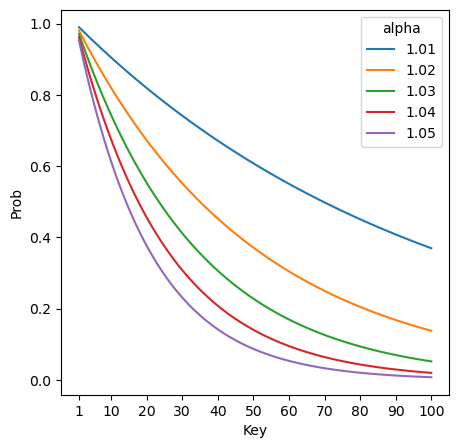

In [2]:
# Show some zipfian distribution
l, h = 1, 100
alphas = [1.01, 1.02, 1.03, 1.04, 1.05]
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
keys = np.linspace(l, h, h-l+1)
for alpha in alphas:
    probs = alpha ** np.negative(keys)
    ax.plot(keys, probs, label=alpha)
ax.legend(title='alpha', loc='upper right')
ax.set_xlabel('Key')
ax.set_ylabel('Prob')
ax.set_xticks(np.linspace(l, h, 11).astype(int))
ax.set_xticklabels(np.linspace(l, h, 11).astype(int))
plt.show()

In [9]:
# Show how simulator works
# Block size: 8
# Peer count: 20
# Key distribution: Zipfian with alpha = 1.01, min = 1, max = 70
# Number of operations: 1000

blocks, succeeds, op_count, success_count = experiment.rw_experiment(
    num_ops=1000, block_size=8, tnx_arrival_rate=-1, n_peers=20, key_range_min=1, key_range_max=70, zipfian_alpha=1.01
)

print('Received tnxs {}, succeeded {}, success rate {:.2f}%'.format(
    op_count, success_count, success_count * 100 / op_count
))

# theoretical success rate
key_list, prob_list = generator.zipfian_generator.compute_keys_and_probs(lo=1, hi=70, a=1.01, reverse=False)
theory_success_rate = theory.compute_success_rate(
    block_size=8, read_keys=key_list, read_key_probs=prob_list, write_keys=key_list, write_key_probs=prob_list,
    read_frac=0.5, write_frac=0.5
)

print('Theoretical success rate: {:.2f}%'.format(theory_success_rate * 100))

Received tnxs 1000, succeeded 938, success rate 93.80%
Theoretical success rate: 96.19%


## Experiment 1: Peers with all-write access pattern

In [54]:
TRIAL_MAX = 50
NUM_OPS = 1000
PEERS = 100

exp_logs = list()
pbar = tqdm(total=5*3*TRIAL_MAX)

# effect of workload skewness
for alpha in [1.01, 1.03, 1.05, 1.07, 1.09]:
    for _ in range(TRIAL_MAX):
        _, _, op_count, success_count = experiment.do_experiment(
            NUM_OPS, 8, -1, get_write_peers(PEERS, 1, 100, alpha)
        )

        exp_logs.append({
            'alpha': alpha,
            'block_size': 8,
            'key_range': 100,
            'success_rate': success_count / op_count
        })

        pbar.update(1)

# effect of block size
for bsize in [4, 8, 16, 32, 64]:
    for _ in range(TRIAL_MAX):
        _, _, op_count, success_count = experiment.do_experiment(
            NUM_OPS, bsize, -1, get_write_peers(PEERS, 1, 100, 1.03)
        )

        exp_logs.append({
            'alpha': 1.03,
            'block_size': bsize,
            'key_range': 100,
            'success_rate': success_count / op_count
        })

        pbar.update(1)

# effect of key range
for kmax in [20, 40, 60, 80, 100]:
    for _ in range(TRIAL_MAX):
        _, _, op_count, success_count = experiment.do_experiment(
            NUM_OPS, 8, -1, get_write_peers(PEERS, 1, kmax, 1.03)
        )

        exp_logs.append({
            'alpha': 1.03,
            'block_size': 8,
            'key_range': kmax,
            'success_rate': success_count / op_count
        })

        pbar.update(1)

pbar.close()
exp_df = pd.DataFrame(exp_logs)
exp_df.to_csv(os.path.join('logs', 'write_peers.csv'), index=False)

  0%|          | 0/750 [00:00<?, ?it/s]

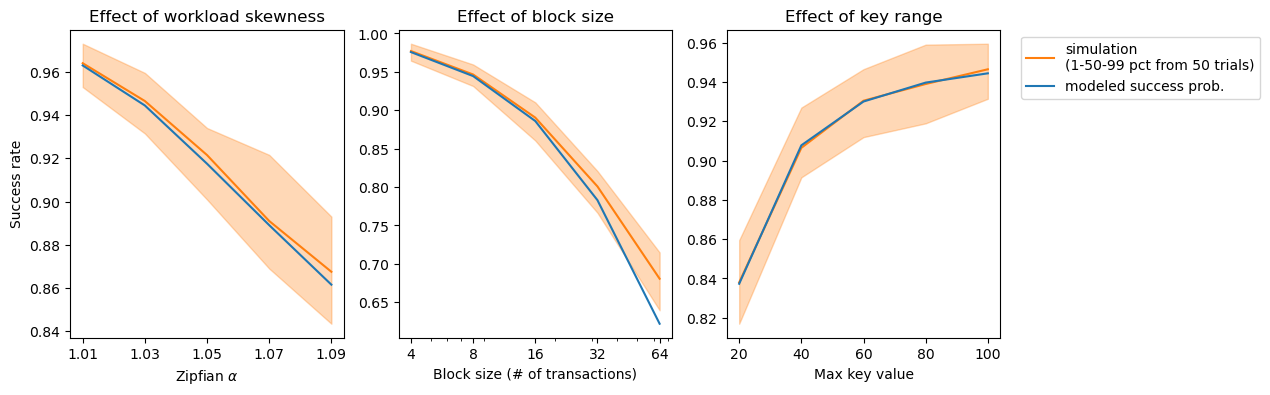

<Figure size 640x480 with 0 Axes>

In [85]:
# plot
exp_df = pd.read_csv('logs/write_peers.csv')

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[1].set_title('Effect of block size')
axs[2].set_title('Effect of key range')

sim_label = 'simulation\n(1-50-99 pct from {} trials)'.format(TRIAL_MAX)
theory_label = 'modeled success prob.'

percentiles = [1, 50, 99]

for idx in range(3):
    ax = axs[idx]
    if idx == 0:
        x_vals = [1.01, 1.03, 1.05, 1.07, 1.09]
        sub_df = exp_df[(exp_df.alpha.isin(x_vals)) & (exp_df.block_size == 8) & (exp_df.key_range == 100)]
        y_vals = list()
        theory_vals = list()
        for x_val in x_vals:
            srs = sub_df[sub_df.alpha == x_val].success_rate.values
            pcts = np.percentile(srs, q=percentiles)
            y_vals.append(pcts)
        
            ks, ps = generator.zipfian_generator.compute_keys_and_probs(1, 100, x_val, False)
            theory_vals.append(
                theory.compute_success_rate(8, ks, ps, ks, ps, 0, 1))

        ax.fill_between(x_vals, [y[0] for y in y_vals], [y[2] for y in y_vals], color='tab:orange', alpha=0.3)
        ax.plot(x_vals, [y[1] for y in y_vals], color='tab:orange', label=sim_label)
        ax.plot(x_vals, theory_vals, color='tab:blue', label=theory_label)

        ax.set_title('Effect of workload skewness')
        ax.set_xlabel('Zipfian $\\alpha$')
        ax.set_ylabel('Success rate')

        ax.set_xticks(x_vals)
        ax.set_xticklabels(x_vals)
    
    elif idx == 1:
        x_vals = [4, 8, 16, 32, 64]
        sub_df = exp_df[(exp_df.alpha == 1.03) & (exp_df.block_size.isin(x_vals)) & (exp_df.key_range == 100)]
        y_vals = list()
        theory_vals = list()
        for x_val in x_vals:
            srs = sub_df[sub_df.block_size == x_val].success_rate.values
            '''
            sr_mean = np.mean(srs)
            sr_std = np.std(srs)
            '''
            pcts = np.percentile(srs, q=percentiles)
            # y_vals.append((sr_mean, sr_std, srs.shape[0]))
            y_vals.append(pcts)
        
            ks, ps = generator.zipfian_generator.compute_keys_and_probs(1, 100, 1.03, False)
            theory_vals.append(
                theory.compute_success_rate(x_val, ks, ps, ks, ps, 0, 1))

        ax.fill_between(x_vals, [y[0] for y in y_vals], [y[2] for y in y_vals], color='tab:orange', alpha=0.3)
        ax.plot(x_vals, [y[1] for y in y_vals], color='tab:orange', label=sim_label)
        ax.plot(x_vals, theory_vals, color='tab:blue', label=theory_label)

        ax.set_title('Effect of block size')
        ax.set_xlabel('Block size (# of transactions)')

        ax.set_xscale('log')
        ax.set_xticks(x_vals)
        ax.set_xticklabels(x_vals)
    
    if idx == 2:
        x_vals = [20, 40, 60, 80, 100]
        sub_df = exp_df[(exp_df.alpha == 1.03) & (exp_df.block_size == 8) & (exp_df.key_range.isin(x_vals))]
        y_vals = list()
        theory_vals = list()
        for x_val in x_vals:
            srs = sub_df[sub_df.key_range == x_val].success_rate.values
            pcts = np.percentile(srs, q=percentiles)
            y_vals.append(pcts)
        
            ks, ps = generator.zipfian_generator.compute_keys_and_probs(1, x_val, 1.03, False)
            theory_vals.append(
                theory.compute_success_rate(8, ks, ps, ks, ps, 0, 1))

        ax.fill_between(x_vals, [y[0] for y in y_vals], [y[2] for y in y_vals], color='tab:orange', alpha=0.3)
        ax.plot(x_vals, [y[1] for y in y_vals], color='tab:orange', label=sim_label)
        ax.plot(x_vals, theory_vals, color='tab:blue', label=theory_label)

        ax.set_title('Effect of key range')
        ax.set_xlabel('Max key value')

        ax.set_xticks(x_vals)
        ax.set_xticklabels(x_vals)

axs[-1].legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.show()
plt.savefig('figs/write_peers.pdf')

## Experiment 2: clients with read-then-write access pattern

In this setting, client will submit a read request for a key, then submit a write request to the same key

In [56]:
TRIAL_MAX = 50
NUM_OPS = 1000
PEERS = 100

exp_logs = list()
pbar = tqdm(total=5*3*TRIAL_MAX)

# effect of workload skewness
for alpha in [1.01, 1.03, 1.05, 1.07, 1.09]:
    for _ in range(TRIAL_MAX):
        _, _, op_count, success_count = experiment.do_experiment(
            NUM_OPS, 8, -1, get_rw_peers(PEERS, 1, 100, alpha)
        )

        exp_logs.append({
            'alpha': alpha,
            'block_size': 8,
            'key_range': 100,
            'success_rate': success_count / op_count
        })

        pbar.update(1)

# effect of block size
for bsize in [4, 8, 16, 32, 64]:
    for _ in range(TRIAL_MAX):
        _, _, op_count, success_count = experiment.do_experiment(
            NUM_OPS, bsize, -1, get_rw_peers(PEERS, 1, 100, 1.03)
        )

        exp_logs.append({
            'alpha': 1.03,
            'block_size': bsize,
            'key_range': 100,
            'success_rate': success_count / op_count
        })

        pbar.update(1)

# effect of key range
for kmax in [20, 40, 60, 80, 100]:
    for _ in range(TRIAL_MAX):
        _, _, op_count, success_count = experiment.do_experiment(
            NUM_OPS, 8, -1, get_rw_peers(PEERS, 1, kmax, 1.03)
        )

        exp_logs.append({
            'alpha': 1.03,
            'block_size': 8,
            'key_range': kmax,
            'success_rate': success_count / op_count
        })

        pbar.update(1)

pbar.close()
exp_df = pd.DataFrame(exp_logs)
exp_df.to_csv(os.path.join('logs', 'rw_peers.csv'), index=False)

  0%|          | 0/750 [00:00<?, ?it/s]

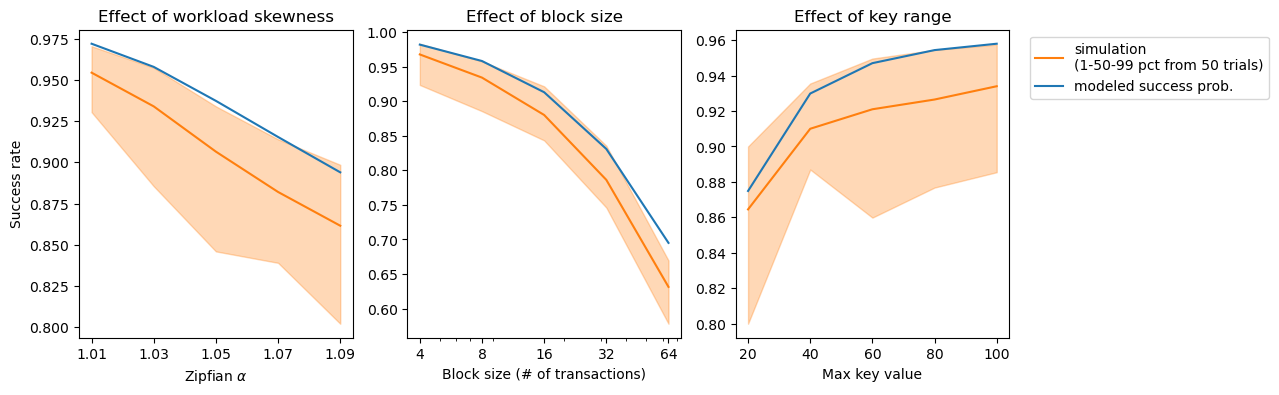

<Figure size 640x480 with 0 Axes>

In [84]:
# plot
exp_df = pd.read_csv('logs/rw_peers.csv')

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[1].set_title('Effect of block size')
axs[2].set_title('Effect of key range')

sim_label = 'simulation\n(1-50-99 pct from {} trials)'.format(TRIAL_MAX)
theory_label = 'modeled success prob.'

percentiles = [1, 50, 99]

for idx in range(3):
    ax = axs[idx]
    if idx == 0:
        x_vals = [1.01, 1.03, 1.05, 1.07, 1.09]
        sub_df = exp_df[(exp_df.alpha.isin(x_vals)) & (exp_df.block_size == 8) & (exp_df.key_range == 100)]
        y_vals = list()
        theory_vals = list()
        for x_val in x_vals:
            srs = sub_df[sub_df.alpha == x_val].success_rate.values
            pcts = np.percentile(srs, q=percentiles)
            y_vals.append(pcts)
        
            ks, ps = generator.zipfian_generator.compute_keys_and_probs(1, 100, x_val, False)
            theory_vals.append(
                theory.compute_success_rate(8, ks, ps, ks, ps, 0.5, 0.5))

        ax.fill_between(x_vals, [y[0] for y in y_vals], [y[2] for y in y_vals], color='tab:orange', alpha=0.3)
        ax.plot(x_vals, [y[1] for y in y_vals], color='tab:orange', label=sim_label)
        ax.plot(x_vals, theory_vals, color='tab:blue', label=theory_label)

        ax.set_title('Effect of workload skewness')
        ax.set_xlabel('Zipfian $\\alpha$')
        ax.set_ylabel('Success rate')

        ax.set_xticks(x_vals)
        ax.set_xticklabels(x_vals)
    
    elif idx == 1:
        x_vals = [4, 8, 16, 32, 64]
        sub_df = exp_df[(exp_df.alpha == 1.03) & (exp_df.block_size.isin(x_vals)) & (exp_df.key_range == 100)]
        y_vals = list()
        theory_vals = list()
        for x_val in x_vals:
            srs = sub_df[sub_df.block_size == x_val].success_rate.values
            '''
            sr_mean = np.mean(srs)
            sr_std = np.std(srs)
            '''
            pcts = np.percentile(srs, q=percentiles)
            # y_vals.append((sr_mean, sr_std, srs.shape[0]))
            y_vals.append(pcts)
        
            ks, ps = generator.zipfian_generator.compute_keys_and_probs(1, 100, 1.03, False)
            theory_vals.append(
                theory.compute_success_rate(x_val, ks, ps, ks, ps, 0.5, 0.5))

        ax.fill_between(x_vals, [y[0] for y in y_vals], [y[2] for y in y_vals], color='tab:orange', alpha=0.3)
        ax.plot(x_vals, [y[1] for y in y_vals], color='tab:orange', label=sim_label)
        ax.plot(x_vals, theory_vals, color='tab:blue', label=theory_label)

        ax.set_title('Effect of block size')
        ax.set_xlabel('Block size (# of transactions)')

        ax.set_xscale('log')
        ax.set_xticks(x_vals)
        ax.set_xticklabels(x_vals)
    
    if idx == 2:
        x_vals = [20, 40, 60, 80, 100]
        sub_df = exp_df[(exp_df.alpha == 1.03) & (exp_df.block_size == 8) & (exp_df.key_range.isin(x_vals))]
        y_vals = list()
        theory_vals = list()
        for x_val in x_vals:
            srs = sub_df[sub_df.key_range == x_val].success_rate.values
            pcts = np.percentile(srs, q=percentiles)
            y_vals.append(pcts)
        
            ks, ps = generator.zipfian_generator.compute_keys_and_probs(1, x_val, 1.03, False)
            theory_vals.append(
                theory.compute_success_rate(8, ks, ps, ks, ps, 0.5, 0.5))

        ax.fill_between(x_vals, [y[0] for y in y_vals], [y[2] for y in y_vals], color='tab:orange', alpha=0.3)
        ax.plot(x_vals, [y[1] for y in y_vals], color='tab:orange', label=sim_label)
        ax.plot(x_vals, theory_vals, color='tab:blue', label=theory_label)

        ax.set_title('Effect of key range')
        ax.set_xlabel('Max key value')

        ax.set_xticks(x_vals)
        ax.set_xticklabels(x_vals)

axs[-1].legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.show()

plt.savefig('figs/rw_peers.pdf')

## Experiment 3: peers read and write from different pattern

In [74]:
TRIAL_MAX = 50
NUM_OPS = 1000
PEERS = 100

exp_logs = list()
pbar = tqdm(total=5*4*TRIAL_MAX)

# effect of read action ratio
for read_prob in [0.1, 0.3, 0.5, 0.7, 0.9]:
    for _ in range(TRIAL_MAX):
        _, _, op_count, success_count = experiment.do_experiment(
            NUM_OPS, 8, -1, get_rw_diff_peers(PEERS, 1, 100, 1.03, read_prob)
        )

        exp_logs.append({
            'alpha': 1.03,
            'block_size': 8,
            'key_range': 100,
            'read_prob': read_prob,
            'success_rate': success_count / op_count
        })

        pbar.update(1)

# effect of workload skewness
for alpha in [1.01, 1.03, 1.05, 1.07, 1.09]:
    for _ in range(TRIAL_MAX):
        _, _, op_count, success_count = experiment.do_experiment(
            NUM_OPS, 8, -1, get_rw_diff_peers(PEERS, 1, 100, alpha, 0.5)
        )

        exp_logs.append({
            'alpha': alpha,
            'block_size': 8,
            'key_range': 100,
            'read_prob': 0.5,
            'success_rate': success_count / op_count
        })

        pbar.update(1)

# effect of block size
for bsize in [4, 8, 16, 32, 64]:
    for _ in range(TRIAL_MAX):
        _, _, op_count, success_count = experiment.do_experiment(
            NUM_OPS, bsize, -1, get_rw_diff_peers(PEERS, 1, 100, 1.03, 0.5)
        )

        exp_logs.append({
            'alpha': 1.03,
            'block_size': bsize,
            'key_range': 100,
            'read_prob': 0.5,
            'success_rate': success_count / op_count
        })

        pbar.update(1)

# effect of key range
for kmax in [20, 40, 60, 80, 100]:
    for _ in range(TRIAL_MAX):
        _, _, op_count, success_count = experiment.do_experiment(
            NUM_OPS, 8, -1, get_rw_diff_peers(PEERS, 1, kmax, 1.03, 0.5)
        )

        exp_logs.append({
            'alpha': 1.03,
            'block_size': 8,
            'key_range': kmax,
            'read_prob': 0.5,
            'success_rate': success_count / op_count
        })

        pbar.update(1)

pbar.close()
exp_df = pd.DataFrame(exp_logs)
exp_df.to_csv(os.path.join('logs', 'rw_diff_peers.csv'), index=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

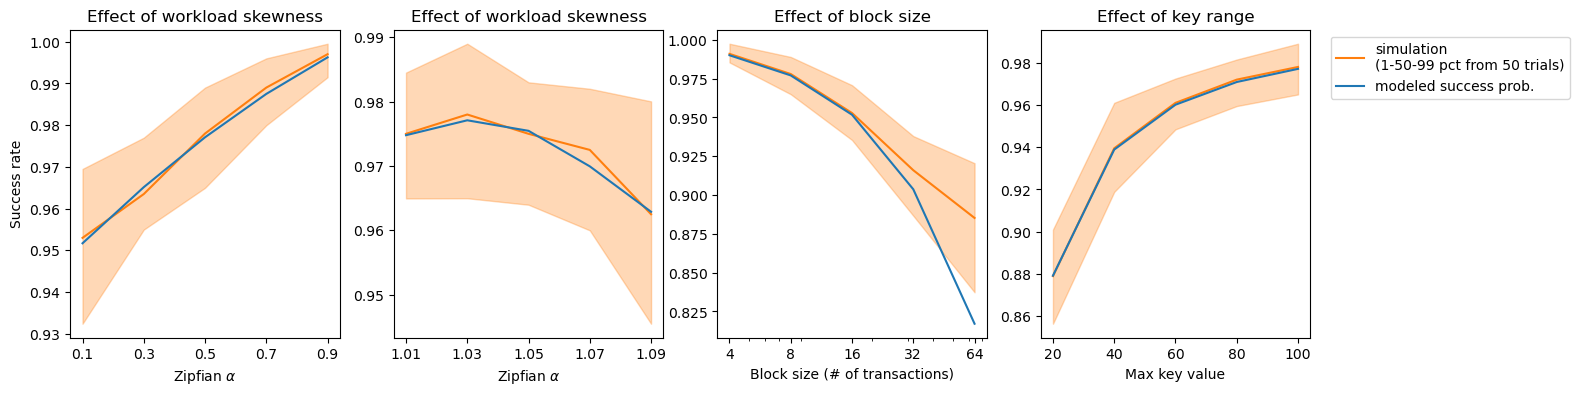

<Figure size 640x480 with 0 Axes>

In [83]:
# plot
exp_df = pd.read_csv('logs/rw_diff_peers.csv')

fig, axs = plt.subplots(1, 4, figsize=(16, 4))

sim_label = 'simulation\n(1-50-99 pct from {} trials)'.format(TRIAL_MAX)
theory_label = 'modeled success prob.'

percentiles = [1, 50, 99]

for idx in range(4):
    ax = axs[idx]
    if idx == 0:
        x_vals = [0.1, 0.3, 0.5, 0.7, 0.9]
        sub_df = exp_df[(exp_df.alpha == 1.03) & (exp_df.block_size == 8) & (exp_df.key_range == 100) & (exp_df.read_prob.isin(x_vals))]
        y_vals = list()
        theory_vals = list()
        for x_val in x_vals:
            srs = sub_df[sub_df.read_prob == x_val].success_rate.values
            pcts = np.percentile(srs, q=percentiles)
            y_vals.append(pcts)
        
            rks, rps = generator.zipfian_generator.compute_keys_and_probs(1, 100, 1.03, False)
            wks, wps = generator.zipfian_generator.compute_keys_and_probs(1, 100, 1.03, True)
            theory_vals.append(
                theory.compute_success_rate(8, rks, rps, wks, wps, x_val, 1 - x_val))

        ax.fill_between(x_vals, [y[0] for y in y_vals], [y[2] for y in y_vals], color='tab:orange', alpha=0.3)
        ax.plot(x_vals, [y[1] for y in y_vals], color='tab:orange', label=sim_label)
        ax.plot(x_vals, theory_vals, color='tab:blue', label=theory_label)

        ax.set_title('Effect of workload skewness')
        ax.set_xlabel('Zipfian $\\alpha$')
        ax.set_ylabel('Success rate')

        ax.set_xticks(x_vals)
        ax.set_xticklabels(x_vals)
    elif idx == 1:
        x_vals = [1.01, 1.03, 1.05, 1.07, 1.09]
        sub_df = exp_df[(exp_df.alpha.isin(x_vals)) & (exp_df.block_size == 8) & (exp_df.key_range == 100) & (exp_df.read_prob ==0.5)]
        y_vals = list()
        theory_vals = list()
        for x_val in x_vals:
            srs = sub_df[sub_df.alpha == x_val].success_rate.values
            pcts = np.percentile(srs, q=percentiles)
            y_vals.append(pcts)
        
            rks, rps = generator.zipfian_generator.compute_keys_and_probs(1, 100, x_val, False)
            wks, wps = generator.zipfian_generator.compute_keys_and_probs(1, 100, x_val, True)
            theory_vals.append(
                theory.compute_success_rate(8, rks, rps, wks, wps, 0.5, 0.5))

        ax.fill_between(x_vals, [y[0] for y in y_vals], [y[2] for y in y_vals], color='tab:orange', alpha=0.3)
        ax.plot(x_vals, [y[1] for y in y_vals], color='tab:orange', label=sim_label)
        ax.plot(x_vals, theory_vals, color='tab:blue', label=theory_label)

        ax.set_title('Effect of workload skewness')
        ax.set_xlabel('Zipfian $\\alpha$')

        ax.set_xticks(x_vals)
        ax.set_xticklabels(x_vals)
    
    elif idx == 2:
        x_vals = [4, 8, 16, 32, 64]
        sub_df = exp_df[(exp_df.alpha == 1.03) & (exp_df.block_size.isin(x_vals)) & (exp_df.key_range == 100) & (exp_df.read_prob ==0.5)]
        y_vals = list()
        theory_vals = list()
        for x_val in x_vals:
            srs = sub_df[sub_df.block_size == x_val].success_rate.values
            '''
            sr_mean = np.mean(srs)
            sr_std = np.std(srs)
            '''
            pcts = np.percentile(srs, q=percentiles)
            # y_vals.append((sr_mean, sr_std, srs.shape[0]))
            y_vals.append(pcts)
        
            rks, rps = generator.zipfian_generator.compute_keys_and_probs(1, 100, 1.03, False)
            wks, wps = generator.zipfian_generator.compute_keys_and_probs(1, 100, 1.03, True)
            theory_vals.append(
                theory.compute_success_rate(x_val, rks, rps, wks, wps, 0.5, 0.5))

        ax.fill_between(x_vals, [y[0] for y in y_vals], [y[2] for y in y_vals], color='tab:orange', alpha=0.3)
        ax.plot(x_vals, [y[1] for y in y_vals], color='tab:orange', label=sim_label)
        ax.plot(x_vals, theory_vals, color='tab:blue', label=theory_label)

        ax.set_title('Effect of block size')
        ax.set_xlabel('Block size (# of transactions)')

        ax.set_xscale('log')
        ax.set_xticks(x_vals)
        ax.set_xticklabels(x_vals)
    
    if idx == 3:
        x_vals = [20, 40, 60, 80, 100]
        sub_df = exp_df[(exp_df.alpha == 1.03) & (exp_df.block_size == 8) & (exp_df.key_range.isin(x_vals)) & (exp_df.read_prob ==0.5)]
        y_vals = list()
        theory_vals = list()
        for x_val in x_vals:
            srs = sub_df[sub_df.key_range == x_val].success_rate.values
            pcts = np.percentile(srs, q=percentiles)
            y_vals.append(pcts)
        
            rks, rps = generator.zipfian_generator.compute_keys_and_probs(1, x_val, 1.03, False)
            wks, wps = generator.zipfian_generator.compute_keys_and_probs(1, x_val, 1.03, True)
            theory_vals.append(
                theory.compute_success_rate(8, rks, rps, wks, wps, 0.5, 0.5))

        ax.fill_between(x_vals, [y[0] for y in y_vals], [y[2] for y in y_vals], color='tab:orange', alpha=0.3)
        ax.plot(x_vals, [y[1] for y in y_vals], color='tab:orange', label=sim_label)
        ax.plot(x_vals, theory_vals, color='tab:blue', label=theory_label)

        ax.set_title('Effect of key range')
        ax.set_xlabel('Max key value')

        ax.set_xticks(x_vals)
        ax.set_xticklabels(x_vals)

axs[-1].legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.show()

plt.savefig('figs/rw_diff_peers.pdf')